### Import libraries

In [1]:
### Author: Andrea Mastropietro © All rights reserved ###

import os

import torch
from torch_geometric.data import  Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear, global_mean_pool
import torch.nn.functional as F

import numpy as np
import random

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pysmiles import read_smiles
from torchdrug import data

from src.utils import create_edge_index, ChemicalDataset

### Set Random Seeds

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load data

In [3]:
DATA_PATH = "data/compound_data/D2_target_vs_random.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on device: ", device)

Working on device:  cuda


In [4]:
df_data = pd.read_csv(DATA_PATH, sep = ",")
display(df_data.head())

,nonstereo_aromatic_smiles,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,0


### Instantiate custom class using TorchDrug
TorchDrug is a library offering useful facitilies for the management of chemical data.

In [5]:
target_field = "label"
smiles_field = "nonstereo_aromatic_smiles"

In [6]:
smiles = df_data[smiles_field].values.tolist()
display(smiles)

['Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1',
 'Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12',
 'Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1',
 'Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1',
 'Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1',
 'Brc1cccc(N2CCN(Cc3cnn4ccccc34)CC2)n1',
 'C#CC1=CCC(N(CCC)CCC)CC1',
 'C#CC1=CCC(N(CCC)CCCCNC(=O)c2ccc(OCCCc3cn(CCCC)nn3)c(OC)c2)CO1',
 'C#CC1=CCC(N(CCC)CCCCn2cc(-c3ccc(-c4ccccc4)cc3)nn2)CC1',
 'C#CCCC(=O)Nc1ccc(CCN(CCC)C2CCc3c(O)cccc3C2)cc1',
 'C#CCN(CCCCN1CCN(c2cccc(Cl)c2Cl)CC1)C1CCc2ccc(O)cc2C1',
 'C#CCN(CCCCN1CCN(c2ccccc2)CC1)C1CCc2ccc(O)cc2C1',
 'C#CCN(CCN1CCN(c2ccccc2)CC1)C1CCc2ccc(O)cc2C1',
 'C#CCOc1c(OC)cc2c3c1-c1cc(N)ccc1CC3N(C)CC2',
 'C#CCOc1c(OC)cc2c3c1-c1cc(NC(C)=O)ccc1CC3N(C)CC2',
 'C#CCOc1c(OC)cc2c3c1-c1cc([N+](=O)[O-])ccc1CC3N(C)CC2',
 'C#CCOc1ccc(CN2CCN(c3ccccc3OC)CC2)cc1OC',
 'C#Cc1cc(CN2CCN(c3ccccc3OC)CC2)c2cccccc1-2',
 'C#Cc1ccc(C(=O)NCCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc1',
 'C#Cc1ccc(C(=O)NCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc1',
 'C#Cc1ccc(C(=O)NCCCCN

In [7]:
mols = []
for i in tqdm(range(len(smiles))):
    mols.append(read_smiles(smiles[i]))

  0%|          | 0/8348 [00:00<?, ?it/s]

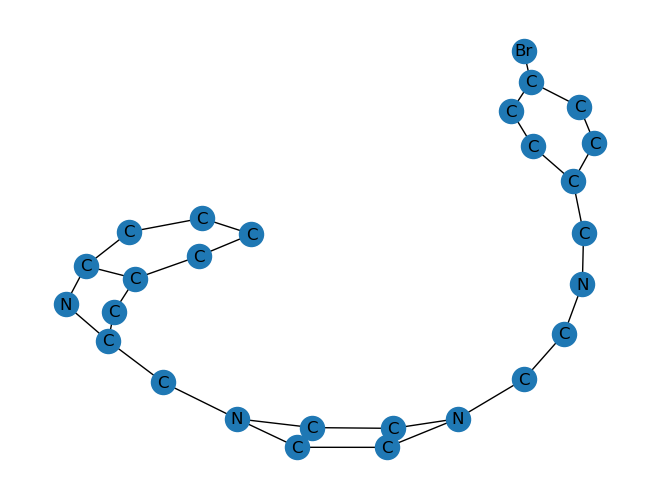

In [8]:
%matplotlib inline
test_molecule = mols[0]
elements = nx.get_node_attributes(test_molecule, name = "element")
nx.draw(test_molecule, with_labels=True, labels = elements, pos=nx.spring_layout(test_molecule))
plt.show()

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(smiles))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(smiles[i], with_hydrogen = False))

  0%|          | 0/8348 [00:00<?, ?it/s]

c:\Users\Mastro\anaconda3\envs\GNN_XAI_Biomedicine_env\lib\site-packages\torchdrug\data\feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


### Create edge index

In [10]:
edge_index_list = []
for mol in tqdm(mols):
    edge_index_list.append(create_edge_index(mol))
display(edge_index_list)

  0%|          | 0/8348 [00:00<?, ?it/s]

[tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  8,
           8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15,
          16, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 22, 22, 23, 23,
          24, 24, 25, 25, 26, 26],
         [ 1,  0,  2, 26,  1,  3,  2,  4,  3,  5, 25,  4,  6,  5,  7,  6,  8,  7,
           9,  8, 10, 24,  9, 11, 10, 12, 11, 13, 23, 12, 14, 13, 15, 22, 14, 16,
          15, 17, 21, 16, 18, 17, 19, 18, 20, 19, 21, 16, 20, 22, 14, 21, 12, 24,
           9, 23,  4, 26,  1, 25]]),
 tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,  7,  7,
           8,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15,
          16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 22],
         [ 1,  0,  2, 22,  1,  3,  2,  4,  3,  5, 18,  4,  6, 17,  5,  7,  6,  8,
           7,  9, 16,  8, 10,  9, 11, 15, 10, 12, 11, 13, 12, 14, 13, 15, 10, 14,
           8, 17,  5, 16,  4, 19,

In [11]:
y = torch.LongTensor(df_data[target_field].values.tolist()).to(device)
display(y)

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')

In [12]:
data_list = []
for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], num_nodes = len(mols[i].nodes)))

  0%|          | 0/8348 [00:00<?, ?it/s]

In [13]:
dataset = ChemicalDataset(".", data_list = data_list)

In [14]:
dataset[0]

Data(x=[27, 67], edge_index=[2, 60], y=[1], num_nodes=27)

### Split Dataset

In [15]:
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]

dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]

### Define GNN Model - GCN

In [16]:
class GCN(torch.nn.Module):
    '''
    4-layer GCN model class.
    '''
    def __init__(self, node_features_dim, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch, edge_weight = None):
        
        x = self.conv1(x.float(), edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_weight = edge_weight)
       
        x = global_mean_pool(x, batch)  

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

### Create Dataloader

In [17]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

### Instantiate the Model

In [18]:
#model instantiation
NUM_NODE_FEATURES = mols_torchdrug_format[0].node_feature.shape[1]
model = GCN(node_features_dim = NUM_NODE_FEATURES, num_classes = dataset.num_classes, hidden_channels=256).to(device)

#training the network
lr =1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
criterion = torch.nn.CrossEntropyLoss() # this is equivalent to the combination of LogSoftmax torch.nn.NLLLoss.

### Define Train and Test Functions

In [19]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

### Train the GNN Model

In [20]:
for epoch in tqdm(range(epochs)):
    train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 000, Train Acc: 0.9250, Val Acc: 0.9113
Epoch: 001, Train Acc: 0.9287, Val Acc: 0.9089
Epoch: 002, Train Acc: 0.9358, Val Acc: 0.9125
Epoch: 003, Train Acc: 0.9428, Val Acc: 0.9245
Epoch: 004, Train Acc: 0.9452, Val Acc: 0.9293
Epoch: 005, Train Acc: 0.9504, Val Acc: 0.9293
Epoch: 006, Train Acc: 0.9512, Val Acc: 0.9329
Epoch: 007, Train Acc: 0.9506, Val Acc: 0.9293
Epoch: 008, Train Acc: 0.9513, Val Acc: 0.9353
Epoch: 009, Train Acc: 0.9554, Val Acc: 0.9365
Epoch: 010, Train Acc: 0.9593, Val Acc: 0.9376
Epoch: 011, Train Acc: 0.9602, Val Acc: 0.9400
Epoch: 012, Train Acc: 0.9572, Val Acc: 0.9353
Epoch: 013, Train Acc: 0.9609, Val Acc: 0.9400
Epoch: 014, Train Acc: 0.9657, Val Acc: 0.9460
Epoch: 015, Train Acc: 0.9668, Val Acc: 0.9460
Epoch: 016, Train Acc: 0.9660, Val Acc: 0.9460
Epoch: 017, Train Acc: 0.9666, Val Acc: 0.9472
Epoch: 018, Train Acc: 0.9701, Val Acc: 0.9520
Epoch: 019, Train Acc: 0.9650, Val Acc: 0.9436
Epoch: 020, Train Acc: 0.9699, Val Acc: 0.9484
Epoch: 021, T

### Test the Model on the Test Set

In [22]:
df_data["label"].value_counts()

label
0    4174
1    4174
Name: count, dtype: int64

In [23]:
test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9820


### Save Model

In [24]:
MODEL_SAVE_FOLDER = "models/"
if not os.path.exists(MODEL_SAVE_FOLDER):
        os.makedirs(MODEL_SAVE_FOLDER)

torch.save(model.state_dict(), MODEL_SAVE_FOLDER + "gcn_model.ckpt")
print("Model saved to {}".format(MODEL_SAVE_FOLDER + "gcn_model.ckpt"))

Model saved to models/gcn_model.ckpt
